## Nbeats model (Neural Basis Expansion Analysis for Time Series)
A fast, interpretable DL model that recreates the mechanisms of statistical models using double residual stacks of fully connected layers.

In [1]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from darts.metrics import mape
from darts.metrics import mase
import numpy as np
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

In [2]:
# Read a pandas DataFrame
df = pd.read_csv('../../../data/prepared/df_energy_climate_2020.csv')

In [3]:
series_price = TimeSeries.from_dataframe(
    df, 
    time_col="datetime",
    value_cols=["energy_price"]
)
series_wind = TimeSeries.from_dataframe(
    df, 
    time_col="datetime",
    value_cols=["wind_speed"]
)
series_not_renewable = TimeSeries.from_dataframe(
    df,
    time_col='datetime',
    value_cols=['not_renewable']
)

In [4]:
splitting_point = (int(len(series_price)*0.20))

# Set aside the second half of series as a validation series
train_price, val_price = series_price[:-splitting_point], series_price[-splitting_point:]

past_wind, future_wind = series_wind[:-splitting_point], series_wind[-splitting_point:]

past_not_renewable, future_not_renewable = series_wind[:-splitting_point], series_wind[-splitting_point:]


In [5]:
scaler = Scaler()

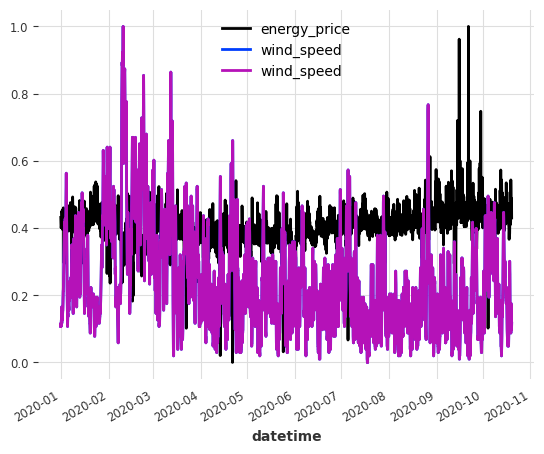

In [6]:
train_price_scaled, past_wind_scaled, past_not_renewable_scaled, future_wind_scaled, future_not_renewable_scaled = scaler.fit_transform([train_price, past_wind, past_not_renewable, future_wind, future_not_renewable])


train_price_scaled.plot()
past_wind_scaled.plot()
past_not_renewable_scaled.plot()

In [7]:
past_covariates = concatenate(
    [
        past_wind_scaled, 
        past_not_renewable_scaled,
        dt_attr(train_price.time_index, 'month', dtype=np.float32),
        dt_attr(train_price.time_index, 'hour', dtype=np.float32),
        dt_attr(train_price.time_index, 'dayofweek', dtype=np.float32)

    ],
    axis='component'
)

future_covariates = concatenate(
    [future_wind_scaled, future_not_renewable_scaled],
    axis='component'

)

In [8]:
model = NBEATSModel(
    input_chunk_length=2016, 
    output_chunk_length=168, 
    random_state=42
)

In [9]:
model.fit(
    train_price_scaled, 
    past_covariates=past_covariates,
    epochs=1,
    verbose=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 101 M 
---------------------------------------------------
101 M     Trainable params
73.9 K    Non-trainable params
101 M     Total params
810.096   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
pred_price = model.predict(
    series=train_price_scaled,
    n=36
)

# scale back
pred_price = scaler.inverse_transform(pred_price)

plt.figure(figsize=(10, 6))
series_price.plot(label='actual price')
pred_price.plot(label='forecast price')

In [ ]:
mape(series_price, pred_price, inter_reduction=np.mean)

/home/user/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/user/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
backtest = model.backtest(
    series_price,
    past_covariates=past_covariates,
    start=0.80,
    forecast_horizon=168,
    verbose=True,
    metric='mape', 
)

  0%|          | 0/1591 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 85.4 M
---------------------------------------------------
85.3 M    Trainable params
61.8 K    Non-trainable params
85.4 M    Total params
683.088   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/user/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 85.4 M
---------------------------------------------------
85.3 M    Trainable params
61.8 K    Non-trainable params
85.4 M    Total params
683.088   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
print(f'Mape = {mape(backtest, series_price):.2f}')

In [ ]:
series_price.plot()
backtest.plot()